Reminder: use `shift + enter` or the run button to run a cell in the notebook

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
import time

In [2]:
x_data = [[]]
y_data = [[]]
voltages = [0]
try:
    import fieldmappingsetup
    %run -i fieldmappingsetup.py
    print("Setup complete.")
except:
    print("ERROR: fieldmappingsetup.py not loaded.")

Setup complete.


If the above cell doesn't work, make sure the FieldMappingSetup.py file is in the same folder as this file.

Click on the plot to mark a point.
Mark several points at a given voltage to map out equipotential lines.
If the plot stops responding run this cell again, your data will be kept.


<IPython.core.display.Javascript object>


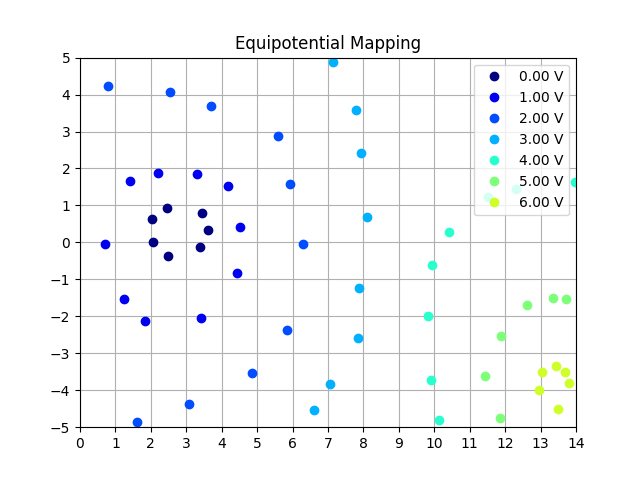

Box(children=(Button(description='Undo Last Point', style=ButtonStyle()), Button(description='New Voltage', st…

Output()

In [3]:
print("Click on the plot to mark a point.")
print("Mark several points at a given voltage to map out equipotential lines.")
print("If the plot stops responding run this cell again, your data will be kept.")

fig, ax = plt.subplots()
ax.set_xlim(0,14)
ax.set_ylim(-5,5)
ax.set_xticks(np.linspace(0,14,15),minor=False)
ax.set_yticks(np.linspace(-5,5,11),minor=False)
ax.grid(True,'both')
ax.set_title("Equipotential Mapping")
def get_color(val):
    return plt.get_cmap('jet')(val/10.0)
# Everything above this is setup for the plot

line, = ax.plot(x_data[0], y_data[0], linestyle="", marker="o",label = "{:0.2f} V".format(voltages[0]),color=get_color(voltages[0]))
linebuilder = LineBuilder(line)

Show_Voltages = widgets.Tab()
new_tab(Show_Voltages)

for index in range(1,len(voltages)):
    ln, = ax.plot(x_data[index], y_data[index], linestyle="", marker="o",label ="{:0.2f} V".format(voltages[index]),color=get_color(voltages[index]))
    linebuilder.restoreline(ln)
    new_tab(Show_Voltages)
    ax.legend()
# The code above sets up things to draw points, and loads previous data if something goes wrong
    
Show_Voltages.observe(on_value_change, 'selected_index')

undo = widgets.Button(description='Undo Last Point')
newline = widgets.Button(description='New Voltage')
savefig = widgets.Button(description='Save Figure')
cleardata = widgets.Button(description='Clear Data')
restoredata = widgets.Button(description='Restore')
loadfromfile = widgets.FileUpload(description='Load File')

undo.on_click(undo_clicked)
newline.on_click(newline_clicked)
savefig.on_click(save_figure)
cleardata.on_click(clear_data)
restoredata.on_click(restore_data)
loadfromfile.observe(load_from_file,'value')

btns=widgets.Box(children=[undo,newline,savefig,cleardata,restoredata,loadfromfile])

output = widgets.Output()
display(btns,Show_Voltages,output)
# All the above creates the user interface

ax.legend();

----

# Don't continue to the rest until you've mapped and saved 3 different configurations!

Keep your last configuration loaded as you run the rest of the code.

The code below will interpolate between the data points you've gathered to make a plot of the expected voltage distribution.

<IPython.core.display.Javascript object>


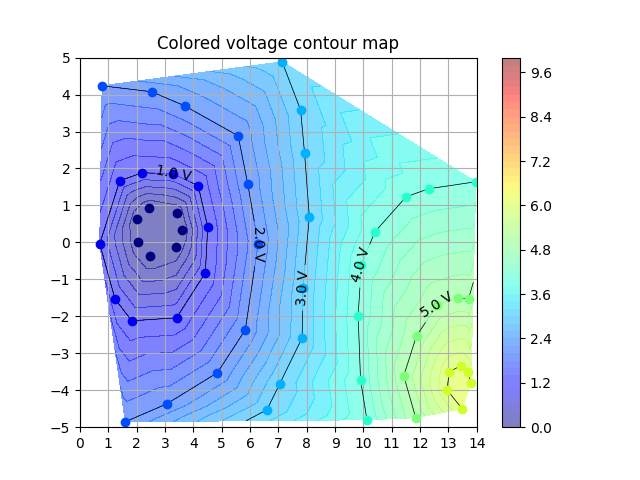

Button(description='Save Figure', style=ButtonStyle())

Output()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim(0,14)
ax.set_ylim(-5,5)
ax.set_xticks(np.linspace(0,14,15),minor=False)
ax.set_yticks(np.linspace(-5,5,11),minor=False)
ax.grid(True,'both')

# This sets up the plot

X = []
Y = []
Z = []

try:
    voltages = linebuilder.voltages # This pulls the data from the plot

    for n in range(len(x_data)):
        X = np.append(X,x_data[n])
        Y = np.append(Y,y_data[n])
        Z = np.append(Z,np.full_like(x_data[n],voltages[n]))
        ax.plot(x_data[n], y_data[n], linestyle="", marker="o",color=get_color(voltages[n]))

    # The above reshapes the data to be suitable for a contour plot

    volts = ax.tricontour(X, Y, Z, levels=np.linspace(0,10,11), linewidths=0.5, colors='k')
    ax.clabel(volts, volts.levels, fmt = '%r V',inline=True)
    cntr = ax.tricontourf(X, Y, Z, levels=np.linspace(0,10,51), cmap="jet",alpha = 0.5)
    fig.colorbar(cntr, ax=ax)
    ax.set_title('Colored voltage contour map')
    plt.show()

    # This creates a colored contour plot from your data, along with equipotential lines ever 1 V

    savefig = widgets.Button(description='Save Figure')
    savefig.on_click(save_figure)
    output = widgets.Output()
    display(savefig,output)
except ValueError:
    print("Not enough data to make contour map")

The following cell will attempt to calculate the electric field from the potentials you've measured.  It will take a minute or two, so be patient.

In [5]:
GZX = []
GZY = []
xval = []
yval = []

# This empties some variables for use in finding field lines

scale_factor = 4
# You may change the scale_factor if you want more fine-grained results
# The scale factor sets how fine of a grid is used for the field lines, in terms of points per inch

progress_bar = widgets.FloatProgress(value=0.0, min=0.0, max=1,description='Processing:')
display(progress_bar)

try:
    for x in np.linspace(0,14,(14*scale_factor)+1):
        tmpx = []
        tmpy = []
        for y in np.linspace(-5,5,(10*scale_factor)+1):
            grad = tri.CubicTriInterpolator(tri.Triangulation(X,Y),Z).gradient(x,y)
                # This is the most critical bit; it finds the gradient of your voltage, i.e. the electric field.
            tmpx = np.append(tmpx,grad[0].data)
            tmpy = np.append(tmpy,grad[1].data)
            xval = np.append(xval,x)
            yval = np.append(yval,y)
        GZX = np.append(GZX,-tmpx)
        GZY = np.append(GZY,-tmpy)
        progress_bar.value = x/14
    progress_bar.description='Complete'
except ValueError:
    print("Not enough data to plot field")

FloatProgress(value=0.0, description='Processing:', max=1.0)

After calculating electrid field lines, you can plot them along with equipotential lines.

You shoulc use the vec_scale slider to uniformly acale all of the field vectors to be visible.

<IPython.core.display.Javascript object>


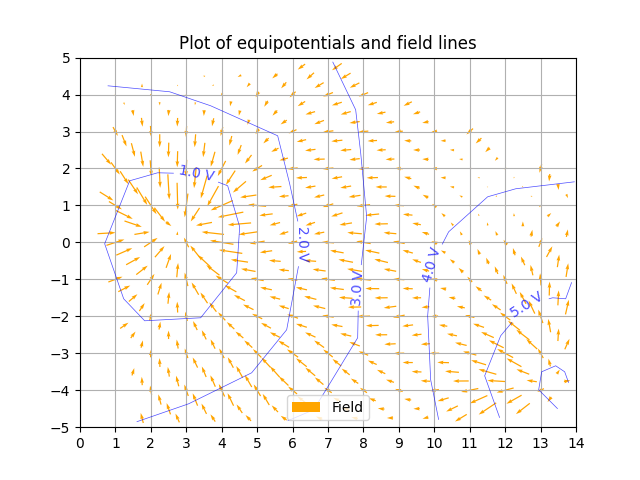

interactive(children=(FloatSlider(value=10.0, description='vec_scale', min=0.1), Output()), _dom_classes=('wid…

Button(description='Save Figure', style=ButtonStyle())

Output()

In [6]:
from ipywidgets import interact
fig, ax = plt.subplots()
ax.set_xlim(0,14)
ax.set_ylim(-5,5)
ax.set_xticks(np.linspace(0,14,15),minor=False)
ax.set_yticks(np.linspace(-5,5,11),minor=False)
ax.grid(True,'both')
ax.set_title("Plot of equipotentials and field lines")

try:
    volts = ax.tricontour(X, Y, Z, levels=np.linspace(0,10,11), linewidths=0.5,alpha = 0.7, colors='b')
    ax.clabel(volts, volts.levels, fmt = '%r V',inline=True)

    E_Field = ax.quiver(xval[::scale_factor],yval[::scale_factor],GZX[::scale_factor],GZY[::scale_factor],color='orange',alpha = 1,scale=10, label = "Field",pivot="mid")
    ax.legend()

    savefig = widgets.Button(description='Save Figure')
    savefig.on_click(save_figure)


    def showfield(vec_scale=10):
        E_Field.scale = 100/vec_scale # smaller numbers yield larger vectors for quiver plots, so this makes the controls more intuitive.
        fig.canvas.draw_idle()
    interact(showfield, vec_scale=(.1,100),continuous_update=False);

    output = widgets.Output()
    display(savefig,output)
except ValueError:
    print("Not enough data to plot field")

Set the correction factor to the spacing between the probe prongs, in cm.

In [7]:
Correction_Factor = 1.0 #cm

If all three vectors are not visible, run the cell again


<IPython.core.display.Javascript object>


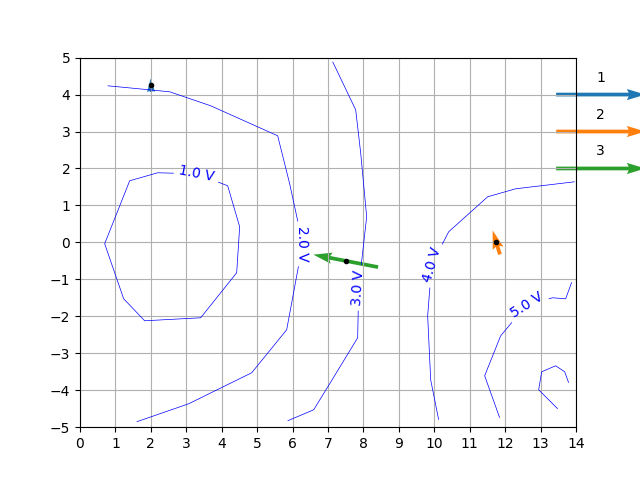

Test point #1
   Coordinates: (2.00,4.25)
   Expected Reading: 0.05 Volts at 358 degrees from +Y axis
Test point #2
   Coordinates: (11.75,0.00)
   Expected Reading: 0.10 Volts at 343 degrees from +Y axis
Test point #3
   Coordinates: (7.50,-0.50)
   Expected Reading: 0.26 Volts at 281 degrees from +Y axis


Button(description='Save Figure', style=ButtonStyle())

Output()

In [8]:
try:
    print("If all three vectors are not visible, run the cell again")
    GMAG = GZX**2 +GZY**2 # Magnitude of the electric field, squared
    max_val = max(GMAG[np.where(np.isnan(GMAG)==False)])
    selected = np.where(GMAG < 0.9*max_val)

    fig, ax = plt.subplots()
    ax.set_xlim(0,14)
    ax.set_ylim(-5,5)
    ax.set_xticks(np.linspace(0,14,15),minor=False)
    ax.set_yticks(np.linspace(-5,5,11),minor=False)
    ax.grid(True,'both')

    volts = ax.tricontour(X, Y, Z, levels=np.linspace(0,10,11), linewidths=0.5, colors='b')
    ax.clabel(volts, volts.levels, fmt = '%r V',inline=True)
    rnd = np.random.choice(selected[0], 3)

    for n,item in enumerate(rnd):
        col = "C" + str(n)
        Q = ax.quiver(xval[item],yval[item],GZX[item],GZY[item],color=col,scale=5,pivot="mid")
        ax.plot(xval[item],yval[item],'k.')
        angle = (np.arctan2(GZX[item],GZY[item])* 180 / np.pi)%360 # finds the angle from an inverse tangent function and some unit conversion
        ax.quiverkey(Q,1.05,.9-(.1*n),.9,label=n+1)
        print("Test point #{}".format(n+1))
        print("   Coordinates: ({:.2f},{:.2f})".format(xval[item],yval[item]))
        print("   Expected Reading: {:.2f} Volts at {:.0f} degrees from +Y axis".format(Correction_Factor*np.sqrt(GMAG[item])/2.54,angle))

    savefig = widgets.Button(description='Save Figure')
    savefig.on_click(save_figure)

    output = widgets.Output()
    display(savefig,output)
except TypeError:
    print("No data to make predictions with")

----